# Introduction

Recently I trained a CNN to classify MNIST with >99% accuracy. Since MNIST is essentially a toy dataset, and a small one at that, I figured now was a great time to extend those learnings by tackling the next toy dataset in the hierarchy: CIFAR-10. This is a subset of 10 classes from a much larger dataset of about 80mil images. The classes are:

* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

The CIFAR-10 [website](https://www.cs.toronto.edu/~kriz/cifar.html) also notes that the classes are mutually exclusive.

# Read in the data

It's been provided to us as a `.tar.gz` compressed file, so I use 7-Zip to extract it (damn Windows).

The data are provided as pickle objects; thankfully, the website above gives us a helpful function to unpickle them. As stated on the website:

>The archive contains the files data_batch_1, data_batch_2, ..., data_batch_5, as well as test_batch. Each of these files is a Python "pickled" object produced with cPickle.
>
>Loaded in this way, each of the batch files contains a dictionary with the following elements:

>* data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
>* labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.
>
>The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:
>* label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_test():
    test = unpickle('data/test_batch')
    meta = unpickle('data/batches.meta')
    return test[b'data'], test[b'labels']

def load_train(n):
    train = unpickle(f'data/data_batch_{n}')
    meta = unpickle('data/batches.meta')
    return train[b'data'], train[b'labels']

def load_names():
    meta = unpickle('data/batches.meta')
    return meta[b'label_names']

def reshape(img):
    r,g,b = np.split(img, 3)
    r = r.reshape((32,32))
    g = g.reshape((32,32))
    b = b.reshape((32,32))

    rgbArray = np.zeros((32,32,3), 'uint8')
    rgbArray[:, :, 0] = r
    rgbArray[:, :, 1] = g
    rgbArray[:, :, 2] = b

    return rgbArray

def plot_img(n, ax=None):
    if ax is not None:
        ax.imshow(reshape(xtest[n]), interpolation='bilinear')
    else:
        ax = plt.imshow(reshape(xtest[n]), interpolation='bilinear')
    ax.axes.set(title=names[ytest[n]].decode('utf-8'))
    ax.axes.axis('off')
    return ax

In [2]:
train = [load_train(n) for n in range(1,6)]
xtest, ytest = load_test()
names = load_names()

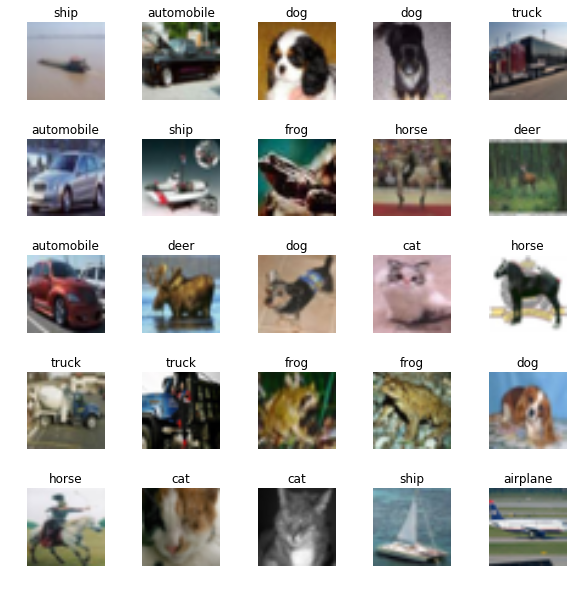

In [33]:
f, axarr = plt.subplots(5, 5, figsize=(10,10))
for row in range(5):
    for col in range(5):
        plot_img(np.random.randint(0,10000), axarr[row][col])
f.subplots_adjust(hspace=0.5)

Logistic model:

In [52]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, Activation, Dense, AveragePooling2D, Flatten
from keras.regularizers import l2

logistic = Sequential()
logistic.add(Dense(10, activation='softmax', input_shape=(3072,), kernel_regularizer=l2(0.0001), activity_regularizer=l2(0.01)))
logistic.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

x = np.concatenate([t[0] for t in train])
y = np.concatenate([t[1] for t in train])

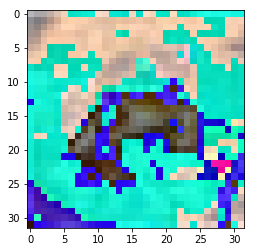

In [42]:
plt.imshow(reshape(((x - x.mean(axis=0)))[0]))

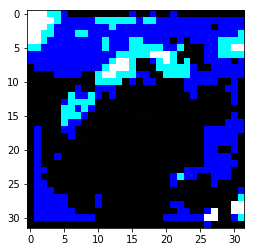

In [41]:
plt.imshow(reshape(((x - x.mean(axis=0)) / x.std())[0]))

In [15]:
logistic.fit((x - x.mean(axis=0)) / x.std(), pd.get_dummies(y), epochs=10)

Epoch 1/10
50000/50000 [==============================] - 10s 197us/step - loss: 2.0919 - acc: 0.3629
Epoch 2/10
50000/50000 [==============================] - 9s 172us/step - loss: 2.0594 - acc: 0.3683
Epoch 3/10
50000/50000 [==============================] - 9s 172us/step - loss: 2.0539 - acc: 0.3703
Epoch 4/10
50000/50000 [==============================] - 9s 172us/step - loss: 2.0626 - acc: 0.3722
Epoch 5/10
50000/50000 [==============================] - 9s 171us/step - loss: 2.0514 - acc: 0.3732
Epoch 6/10
50000/50000 [==============================] - 9s 173us/step - loss: 2.0451 - acc: 0.3749
Epoch 7/10
50000/50000 [==============================] - 9s 175us/step - loss: 2.0501 - acc: 0.3722
Epoch 8/10
50000/50000 [==============================] - 9s 178us/step - loss: 2.0469 - acc: 0.3746
Epoch 9/10
50000/50000 [==============================] - 9s 177us/step - loss: 2.0528 - acc: 0.3764
Epoch 10/10
50000/50000 [==============================] - 9s 178us/step - loss: 2.0286 - 

In [17]:
(logistic.predict((xtest - x.mean(axis=0)) / x.std()).argmax(axis=1) == ytest).mean()

0.3318

Simple conv net:

In [68]:
convolutional = Sequential()

convolutional.add(
    Conv2D(
        input_shape=(32,32,3),
        filters=20,
        kernel_size=(14,14),
        strides=(1,1),
        padding='same',
        activation='relu',
        use_bias=True,
    )
)

convolutional.add(AveragePooling2D())

convolutional.add(
    Conv2D(
        filters=40,
        kernel_size=(7,7),
        strides=(1,1),
        padding='same',
        activation='relu',
        use_bias=True,
    )
)

convolutional.add(AveragePooling2D())

convolutional.add(
    Conv2D(
        filters=150,
        kernel_size=(4,4),
        strides=(1,1),
        padding='same',
        activation='relu',
        use_bias=True,
    )
)

convolutional.add(AveragePooling2D())

convolutional.add(Flatten())

convolutional.add(
    Dense(10,
          activation='softmax',
#           kernel_regularizer=l2(0.00000000001),
#           activity_regularizer=l2(0.0000000001)
         )
)

# optimizer = SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False)

convolutional.compile(
    optimizer='adam', # (SGD | Adagrad) | Adadelta | (RMSprop | Adam | Adamax | Nadam)
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [69]:
xtrain_reshaped = np.zeros((50000, 32, 32, 3))
for i, img in enumerate(x):
    xtrain_reshaped[i] = reshape(img)
xtrain_reshaped = (xtrain_reshaped - xtrain_reshaped.mean(axis=0)) / xtrain_reshaped.std()

In [70]:
xtest_reshaped = np.zeros((10000, 32, 32, 3))
for i, img in enumerate(xtest):
    xtest_reshaped[i] = reshape(img)
xtest_reshaped = (xtest_reshaped - xtrain_reshaped.mean(axis=0)) / xtrain_reshaped.std()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


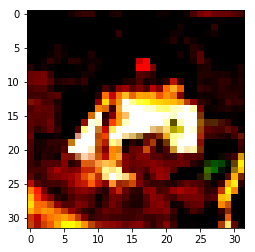

In [71]:
plt.imshow(xtrain_reshaped[0])

In [73]:
h = convolutional.fit(xtrain_reshaped, pd.get_dummies(y), shuffle=True, epochs=30, batch_size=500, validation_data=(xtest_reshaped, pd.get_dummies(ytest)))

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 11s 226us/step - loss: 1.5177 - acc: 0.4583 - val_loss: 10.3041 - val_acc: 0.3307
Epoch 2/30
50000/50000 [==============================] - 11s 220us/step - loss: 1.3333 - acc: 0.5305 - val_loss: 9.9308 - val_acc: 0.3547
Epoch 3/30
50000/50000 [==============================] - 11s 221us/step - loss: 1.2020 - acc: 0.5786 - val_loss: 9.4880 - val_acc: 0.3860
Epoch 4/30
50000/50000 [==============================] - 11s 221us/step - loss: 1.1103 - acc: 0.6121 - val_loss: 10.5144 - val_acc: 0.3290
Epoch 5/30
50000/50000 [==============================] - 11s 224us/step - loss: 1.0213 - acc: 0.6453 - val_loss: 9.3021 - val_acc: 0.4018
Epoch 6/30
50000/50000 [==============================] - 11s 225us/step - loss: 0.9588 - acc: 0.6695 - val_loss: 8.6347 - val_acc: 0.4416
Epoch 7/30
50000/50000 [==============================] - 11s 223us/step - loss: 0.8945 - acc: 0.6884 - val_loss: 

In [74]:
(convolutional.predict(xtest_reshaped).argmax(axis=1) == ytest).mean()

0.4787